<a href="https://colab.research.google.com/github/bachaudhry/foundations_to_stable_diffusion/blob/main/28_LSUN_diffusion_latents_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Update path to load modules and models directly from G Drive
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive


In [2]:
!pip install datasets torcheval fastprogress

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompa

In [3]:
import os, shutil
import pkg_resources
from diffusers import UNet2DModel, UNet2DConditionModel
from diffusers.models import AutoencoderKL #HF moved the older autoencoder to models
from fastprogress import progress_bar
from glob import glob
from copy import deepcopy
import timm

<ipython-input-3-c675acd3a33a>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
from course22p2.miniai.datasets import *
from course22p2.miniai.conv import *
from course22p2.miniai.learner import *
from course22p2.miniai.activations import *
from course22p2.miniai.init import *
from course22p2.miniai.sgd import *
from course22p2.miniai.resnet import *
from course22p2.miniai.augment import *
from course22p2.miniai.accel import *
from course22p2.miniai.training import *
from course22p2.miniai.imports import *
from course22p2.miniai.diffusion import *

In [5]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [6]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [7]:
bs = 64

In [8]:
# read_image is highly optimized for this op.
# .RGB ensures conversion of image types to required outputs.
def to_img(f): return read_image(f, mode=ImageReadMode.RGB)/255

In [9]:
# converting the images to latents
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True) #search for filetypes

    def __len__(self): return len(self.files)

    def __getitem__(self, i): return to_img(self.files[i])[:, :256, :256] # crop last dims of images to reduce some compute and align sizes.

In [10]:
ds = ImagesDS(path/f'**/*.jpg') # search recursively for all jpeg files in the bedroomm folder.

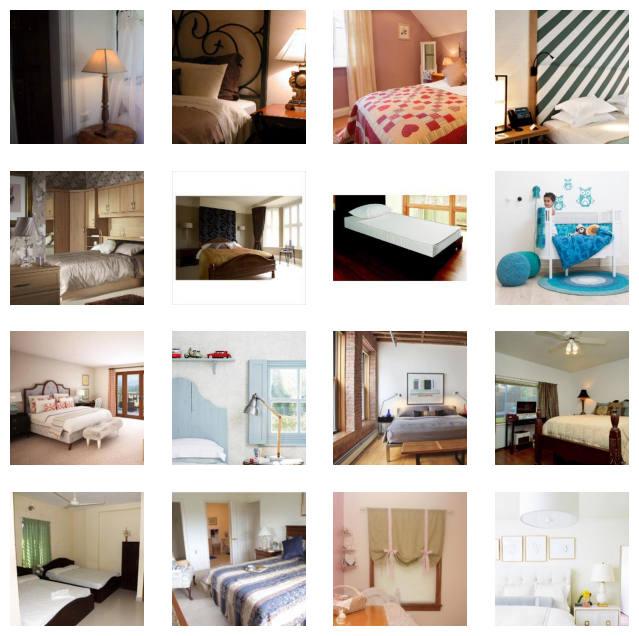

In [11]:
dl = DataLoader(ds, batch_size=bs, num_workers=fc.defaults.cpus) # Load batches with max cpus in parallel.
xb = next(iter(dl))
show_images(xb[:16], imsize=2)

In [12]:
xb[:16].shape

torch.Size([16, 3, 256, 256])

In [13]:
# Total number of floats.
16*3*256*256

3145728

## **Using a Pre-Trained VAE**

In [14]:
# Grabbing pretrained encoder.
# Turn of gradient computations inplace
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [15]:
xe = vae.encode(xb.cuda()) # encode

In [16]:
xs = xe.latent_dist.mean[:16]
xs.shape

torch.Size([16, 4, 32, 32])

In [17]:
# Comparison of original vs compressed / encoded image sizes. % difference
(16*3*256*256) / (16*4*32*32)

48.0

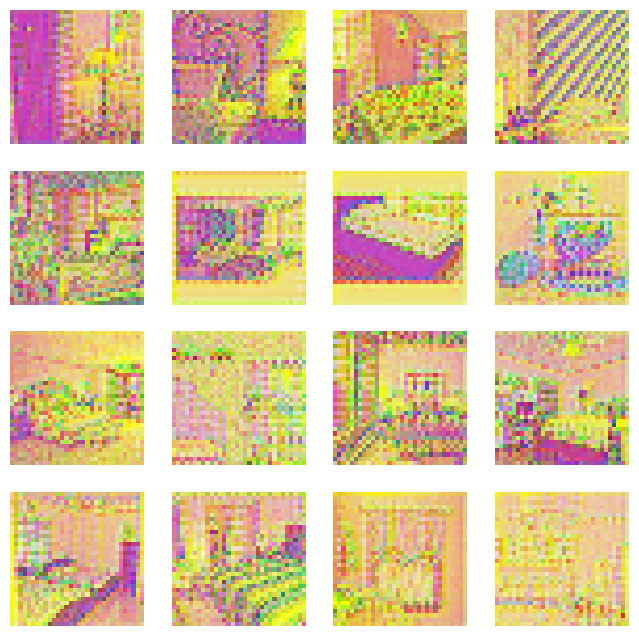

In [18]:
# Grab images and first three channels
# Sigmoid ensures images fall between 0 and 1
show_images(((xs[:16, :3]) / 4).sigmoid(), imsize=2)

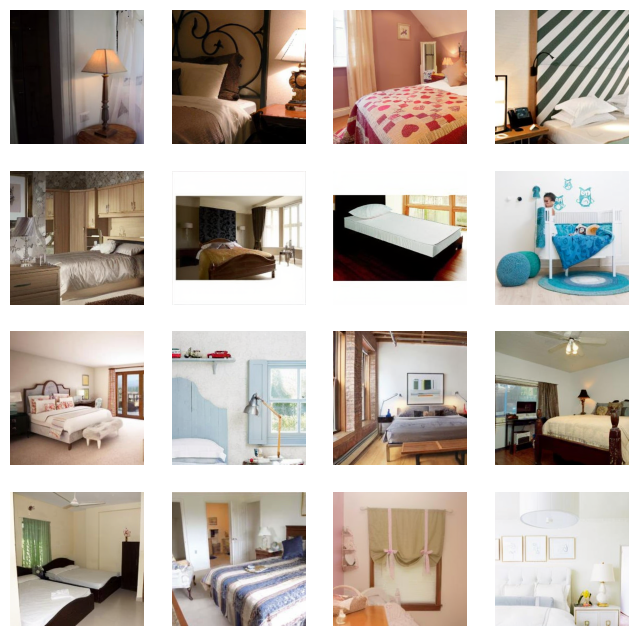

In [19]:
xd = to_cpu(vae.decode(xs)) # Decode tensor
show_images(xd['sample'].clamp(0, 1), imsize=2)

Reconstructed images for quality checks before passing them to the diffusion model. The [`sd-vae-ft-ema`](https://huggingface.co/stabilityai/sd-vae-ft-ema) VAE has a known limitation in regenerating writing / text in images. The creators mention:

> We publish two kl-f8 autoencoder versions, finetuned from the original kl-f8 autoencoder on a 1:1 ratio of LAION-Aesthetics and LAION-Humans, an unreleased subset containing only SFW images of humans. The intent was to fine-tune on the Stable Diffusion training set (the autoencoder was originally trained on OpenImages) but also enrich the dataset with images of humans to improve the reconstruction of faces. The first, ft-EMA, was resumed from the original checkpoint, trained for 313198 steps and uses EMA weights.
>
> It uses the same loss configuration as the original checkpoint (L1 + LPIPS). The second, ft-MSE, was resumed from ft-EMA and uses EMA weights and was trained for another 280k steps using a different loss, with more emphasis on MSE reconstruction (MSE + 0.1 * LPIPS). It produces somewhat ``smoother'' outputs. The batch size for both versions was 192 (16 A100s, batch size 12 per GPU). To keep compatibility with existing models, only the decoder part was finetuned; the checkpoints can be used as a drop-in replacement for the existing autoencoder.

Based on Perplexity, these are some additional details:

>   **Training Data**: It was fine-tuned on a combination of the LAION-Aesthetics and LAION-Humans datasets to enhance the reconstruction of faces and human subjects.
>
>   **Loss Configuration**: The model uses the same loss configuration as the original kl-f8 autoencoder, which includes L1 loss and LPIPS (Learned Perceptual Image Patch Similarity).
>
>   **Exponential Moving Average (EMA) Weights**: The ft-EMA version utilizes EMA weights, which help stabilize the training process and improve model performance.
>
>   **Training Steps**: The model was trained for 313,198 steps.
>
>   **Performance**: Compared to the original kl-f8 VAE, the ft-EMA model shows slightly improved performance, with a lower rFID score of 4.42 versus 4.99 for the original.
>
>   **Applications**: It can be used as a drop-in replacement for the original autoencoder in the Stable Diffusion pipeline, potentially leading to improved downstream generation results. Additionally, it is suitable for tasks like image compression and editing.
>
>   **Variants**: There is another variant, sd-vae-ft-mse, which emphasizes MSE reconstruction and produces smoother outputs.


To read more about Learned Perceptual Image Patch Similarity (LPIPS) read the [paper and the visit the associated Github page](https://richzhang.github.io/PerceptualSimilarity/).

In [20]:
# We will use Memory Mapped Numpy File (NPMM) format to handle in memory tasks more efficiently.
mmpath = Path('data/bedroom/data.npmm')

In [21]:
len(ds)

303125

In [22]:
mmshape = (303125, 4, 32, 32)

In [23]:
if not mmpath.exists(): # Create and store npmm file on disk. Shapes are the same as our images.
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    for b in progress_bar(dl): # Grab a mini batch
        n = len(b)
        # Encode and get the means of the latents and convert to numpy since pytorch doesn't have a memory mapping tool (as of 2023)
        a[i : i+n] = to_cpu(vae.encode(b.cuda()).latent_dist.mean).numpy()
        i += n
    a.flush() # Ensure that the contents of the cache are written to disk.
    del(a)

In [24]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape) # apply memory mapping

In [25]:
b = torch.tensor(lats[:16]) # Verify

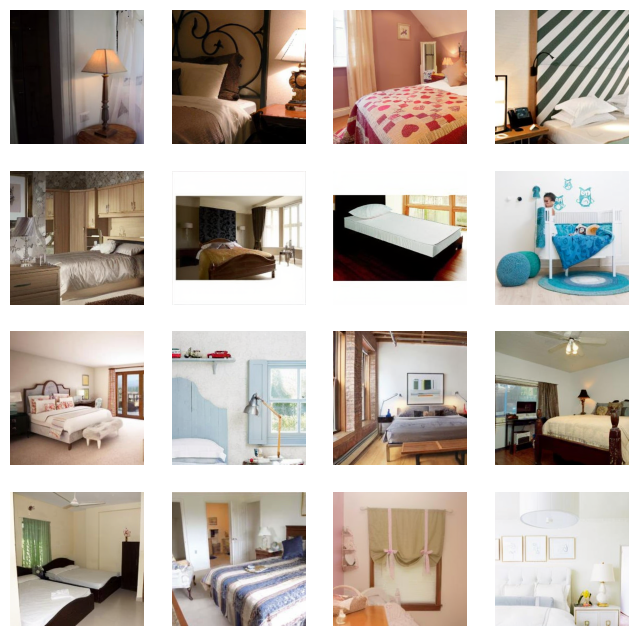

In [26]:
xd = to_cpu(vae.decode(b.cuda()))
show_images(xd['sample'].clamp(0,1), imsize=2)

## **Noisify**

We are now able to apply pipeline operations such as Noisify using numpy, which is pretty cool!! These foundational concepts should be applied more regularly.

In [27]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [28]:
def collate_ddpm(b): return noisify(default_collate(b)*0.2) # Ensure unit standard dev.

In [29]:
n = len(lats)

In [30]:
# Create training and validation sets.
tds = lats[:n // 10*9] # First 90%
vds = lats[ n // 10*9:]# Last 10%

In [31]:
bs = 128

In [32]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [33]:
(xt, t), eps = b = next(iter(dls.train))

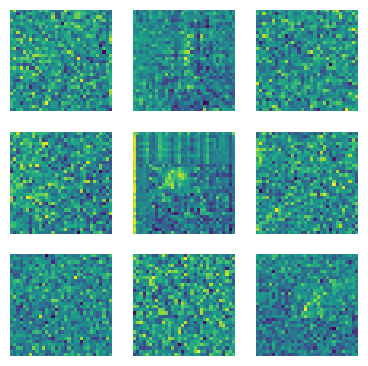

In [34]:
show_images(xt[:9, 0], imsize=1.5)

In [35]:
xte = vae.decode(xt[:9].cuda()*5)['sample']

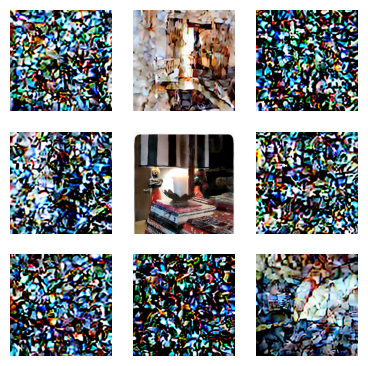

In [36]:
show_images(xte.clamp(0,1), imsize=1.5)

## **Train Latent Diffusion Model**

In [37]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [38]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=4, out_channels=4, nfs=(128, 256, 512, 768), num_layers=2,
                     attn_start=1, attn_chans=16)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/content/drive/MyDrive/Colab Notebooks/miniai/accel.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


loss,epoch,train
0.296,0,train
0.273,0,eval


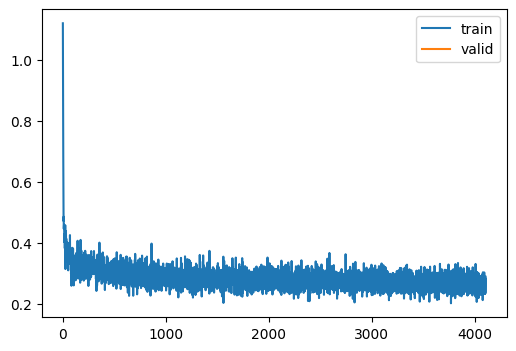

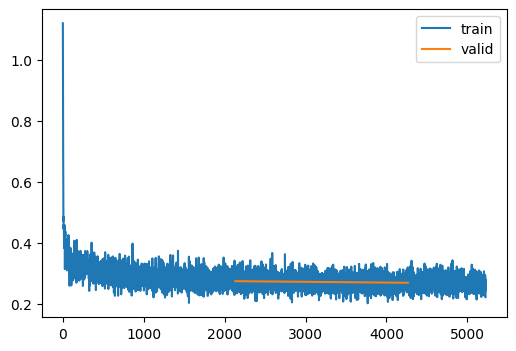

loss,epoch,train
0.296,0,train
0.273,0,eval
0.270,1,train
0.268,1,eval


In [ ]:
learn.fit(epochs) # Loss will be higher since the model tries to generate latent pixels which is a much more difficult task

In [ ]:
# Save model state_dict()
torch.save(learn.model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/lsun-bed-diff-latents.pkl')

## **Sampling**

In [ ]:
sz = (16, 4, 32, 32)

In [ ]:
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)

In [ ]:
s = preds[-1]*5

In [ ]:
# Decode since what we're predicting is latents.
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))

In [ ]:
show_images(pd['sample'][:9].clamp(0,1), imsize=5)